In [ ]:
provider = IBMQ.load_account()

In [228]:
#from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, IBMQ, transpile 

import qiskit
import math
import numpy as np
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram


# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error, amplitude_damping_error

In [229]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [245]:
# Build noise circuit 

n_qubits = 1
noise_circ = QuantumCircuit(n_qubits)
noise_circ.h(0)
noise_circ.u(math.pi/3, 0, math.pi/6, 0)
noise_circ.x(0)
noise_circ.save_density_matrix(label = 'density')
noise_circ.measure_all()
print(noise_circ)

        ┌───┐┌──────────────┐┌───┐ ░  ░ ┌─┐
     q: ┤ H ├┤ U(π/3,0,π/6) ├┤ X ├─░──░─┤M├
        └───┘└──────────────┘└───┘ ░  ░ └╥┘
meas: 1/═════════════════════════════════╩═
                                         0 


In [246]:
# Building noise models 

## Bit-flip error - on measurement 
p_bitflip_1 = 0.1
p_bitflip_2 = 0.5
p_bitflip_3 = 0.9
error_bitflip_1 = pauli_error([('X',p_bitflip_1), ('I', 1 - p_bitflip_1)])
error_bitflip_2 = pauli_error([('X',p_bitflip_2), ('I', 1 - p_bitflip_2)])
error_bitflip_3 = pauli_error([('X',p_bitflip_3), ('I', 1 - p_bitflip_3)])
noise_bitflip_1 = NoiseModel()
noise_bitflip_2 = NoiseModel()
noise_bitflip_3 = NoiseModel()
noise_bitflip_1.add_all_qubit_quantum_error(error_bitflip_1, ['u'])
noise_bitflip_2.add_all_qubit_quantum_error(error_bitflip_2, ['u'])
noise_bitflip_3.add_all_qubit_quantum_error(error_bitflip_3, ['u'])

## Phase-flip error 
p_phaseflip_1 = 0.1
p_phaseflip_2 = 0.5
p_phaseflip_3 = 0.9
error_phaseflip_1 = pauli_error([('Z',p_phaseflip_1), ('I', 1 - p_phaseflip_1)])
error_phaseflip_2 = pauli_error([('Z',p_phaseflip_2), ('I', 1 - p_phaseflip_2)])
error_phaseflip_3 = pauli_error([('Z',p_phaseflip_3), ('I', 1 - p_phaseflip_3)])
noise_phaseflip_1 = NoiseModel()
noise_phaseflip_2 = NoiseModel()
noise_phaseflip_3 = NoiseModel()
noise_phaseflip_1.add_all_qubit_quantum_error(error_phaseflip_1, ['u'])
noise_phaseflip_2.add_all_qubit_quantum_error(error_phaseflip_2, ['u'])
noise_phaseflip_3.add_all_qubit_quantum_error(error_phaseflip_3, ['u'])

## Depolarizing error 
p_depolarizing_1 = 0.1
p_depolarizing_2 = 0.5
p_depolarizing_3 = 0.9
error_depolarizing_1 = depolarizing_error(p_depolarizing_1, 1)
error_depolarizing_2 = depolarizing_error(p_depolarizing_2, 1)
error_depolarizing_3 = depolarizing_error(p_depolarizing_3, 1)
noise_depolarizing_1 = NoiseModel()
noise_depolarizing_2 = NoiseModel()
noise_depolarizing_3 = NoiseModel()
noise_depolarizing_1.add_all_qubit_quantum_error(error_depolarizing_1, ['u'])
noise_depolarizing_2.add_all_qubit_quantum_error(error_depolarizing_2, ['u'])
noise_depolarizing_3.add_all_qubit_quantum_error(error_depolarizing_3, ['u'])

## Amplitude damping 
p_amp_damp_1 = 0.1
p_amp_damp_2 = 0.5
p_amp_damp_3 = 0.9
error_amp_damp_1 = amplitude_damping_error(p_amp_damp_1, 1)
error_amp_damp_2 = amplitude_damping_error(p_amp_damp_2, 1)
error_amp_damp_3 = amplitude_damping_error(p_amp_damp_3, 1)
noise_amp_damp_1 = NoiseModel()
noise_amp_damp_2 = NoiseModel()
noise_amp_damp_3 = NoiseModel()
noise_amp_damp_1.add_all_qubit_quantum_error(error_amp_damp_1, ['u'])
noise_amp_damp_2.add_all_qubit_quantum_error(error_amp_damp_2, ['u'])
noise_amp_damp_3.add_all_qubit_quantum_error(error_amp_damp_3, ['u'])

In [247]:
# Define simulators 
sim_ideal = AerSimulator()
sim_noise = AerSimulator(noise_model = noise_amp_damp_2)



In [248]:
# Execute my ideal circuit
result_ideal = sim_ideal.run(noise_circ).result()


In [249]:
result_ideal.get_counts()

{'1': 130, '0': 894}

In [250]:
# Execute my noisy circuit
circ_tnoise = transpile(noise_circ, sim_noise)
result_bit_flip = sim_noise.run(circ_tnoise).result()

In [251]:
bit_flip_counts = result_bit_flip.get_counts()

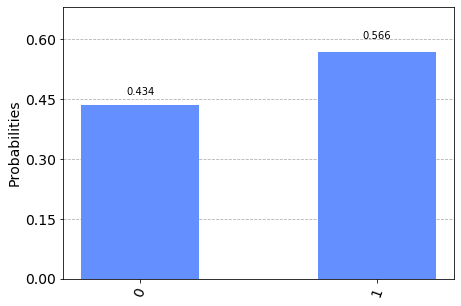

In [252]:
plot_histogram(bit_flip_counts)

In [226]:
result_bit_flip

Result(backend_name='aer_simulator', backend_version='0.10.4', qobj_id='5f21dafa-cbc1-4fdc-bf48-9865984ec8d4', job_id='517d16a4-65c4-41a7-96ff-883854deb78c', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 210, '0x1': 814}, density_matrix=DensityMatrix([[0.2       +0.j , 0.21650635-0.2j],
               [0.21650635+0.2j, 0.8       +0.j ]],
              dims=(2,))), header=QobjExperimentHeader(clbit_labels=[['meas', 0]], creg_sizes=[['meas', 1]], global_phase=0.33347317225183204, memory_slots=1, metadata={}, n_qubits=1, name='circuit-529', qreg_sizes=[['q', 1]], qubit_labels=[['q', 0]]), status=DONE, seed_simulator=2699426670, metadata={'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': False, 'parallel_state_update': 4, 'parallel_shots': 1, 'device': 'CPU', 'active_input_qubits': [0], 'measure_sampling': True, 'num_clbits': 1, 'input_qubit_map': [[0, 0]], 'num_qubits': 1, 'method': 'densi